### 1. Импорты библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from typing import Tuple, Dict, Any, List
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, 
    f1_score, confusion_matrix, roc_curve, precision_recall_curve, 
    auc, average_precision_score
)
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import optuna
from optuna.samplers import TPESampler
import json
from collections import defaultdict

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

### 2. Константы

In [2]:
RANDOM_STATE = 42
N_JOBS = -1
THRESHOLD_AUC = 0.75

### 3. EDA

In [3]:
class DataAnalyzer:
    
    def __init__(self, train_path: str, test_path: str):
        self.train_path = train_path
        self.test_path = test_path
        self.train_df = None
        self.test_df = None
        
    def load_data(self):
        self.train_df = pd.read_csv(self.train_path)
        self.test_df = pd.read_csv(self.test_path)
        return self.train_df, self.test_df
    
    def basic_info(self):
        print(f"Размер train: {self.train_df.shape}")
        print(f"Размер test: {self.test_df.shape}")
        
        print("\nПервые 5 строк train:")
        print(self.train_df.head())
        
        print("\nТипы данных:")
        print(self.train_df.dtypes)
        
        print("\nПропущенные значения в train:")
        missing = self.train_df.isnull().sum()
        print(missing[missing > 0])
        
        if self.train_df.isnull().sum().sum() > 0:
            print(f"\nВсего пропусков: {self.train_df.isnull().sum().sum()}")
    
    def target_analysis(self, target_col: str = 'LoanApproved'):
        if target_col not in self.train_df.columns:
            raise ValueError(f"Колонка {target_col} не найдена в данных")
                    
        nan_count = self.train_df[target_col].isnull().sum()
        if nan_count > 0:
            print(f"В целевой переменной {nan_count} NaN значений")
        
        target_counts = self.train_df[target_col].value_counts(dropna=True)
        print("Распределение (без NaN):")
        print(target_counts)
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        axes[0].bar(target_counts.index.astype(str), target_counts.values)
        axes[0].set_title('Распределение целевой переменной')
        axes[0].set_xlabel(target_col)
        axes[0].set_ylabel('Количество')
        for i, v in enumerate(target_counts.values):
            axes[0].text(i, v + 0.01 * max(target_counts.values), str(v), ha='center')
        
        axes[1].pie(target_counts.values, labels=target_counts.index.astype(str), 
                   autopct='%1.1f%%', startangle=90)
        axes[1].set_title('Доли классов')
        
        plt.tight_layout()
        plt.show()
        
        return target_counts
    
    def correlation_analysis(self):
        
        numeric_cols = self.train_df.select_dtypes(include=[np.number]).columns
        
        if len(numeric_cols) > 1:
            corr_matrix = self.train_df[numeric_cols].corr()
            
            plt.figure(figsize=(12, 10))
            sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', 
                       center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
            plt.title('Матрица корреляций', fontsize=16, pad=20)
            plt.tight_layout()
            plt.show()
            
            print("\nСильные корреляции (|r| > 0.5):")
            strong_corr = []
            for i in range(len(corr_matrix.columns)):
                for j in range(i+1, len(corr_matrix.columns)):
                    if abs(corr_matrix.iloc[i, j]) > 0.5:
                        strong_corr.append((
                            corr_matrix.columns[i], 
                            corr_matrix.columns[j], 
                            corr_matrix.iloc[i, j]
                        ))
            
            if strong_corr:
                for col1, col2, corr in sorted(strong_corr, key=lambda x: abs(x[2]), reverse=True):
                    print(f"{col1} - {col2}: {corr:.3f}")
            else:
                print("Нет сильных корреляций")
                
            return corr_matrix
        else:
            print("Недостаточно числовых признаков для анализа корреляций")
            return None
    
    def feature_distributions(self, n_features: int = 5):
        
        numeric_cols = self.train_df.select_dtypes(include=[np.number]).columns.tolist()
        if 'LoanApproved' in numeric_cols:
            numeric_cols.remove('LoanApproved')
        
        cols_to_plot = numeric_cols[:min(n_features, len(numeric_cols))]
        
        if cols_to_plot:
            n_rows = int(np.ceil(len(cols_to_plot) / 3))
            fig, axes = plt.subplots(n_rows, 3, figsize=(15, n_rows * 4))
            axes = axes.flatten() if n_rows > 1 else [axes]
            
            for idx, col in enumerate(cols_to_plot):
                axes[idx].hist(self.train_df[col].dropna(), bins=30, alpha=0.7, edgecolor='black')
                axes[idx].set_title(f'Распределение {col}', fontsize=12)
                axes[idx].set_xlabel(col)
                axes[idx].set_ylabel('Частота')
            
            for idx in range(len(cols_to_plot), len(axes)):
                axes[idx].axis('off')
            
            plt.tight_layout()
            plt.show()
    
    def scatter_analysis(self, feature_pairs: list = None):
        
        if feature_pairs is None:
            numeric_cols = self.train_df.select_dtypes(include=[np.number]).columns.tolist()
            if 'LoanApproved' in numeric_cols:
                numeric_cols.remove('LoanApproved')
            
            if len(numeric_cols) >= 2:
                feature_pairs = [(numeric_cols[0], numeric_cols[1])]
            else:
                print("Недостаточно признаков для scatter plot")
                return
        
        for x_col, y_col in feature_pairs:
            if x_col in self.train_df.columns and y_col in self.train_df.columns:
                plt.figure(figsize=(10, 6))
                scatter = plt.scatter(self.train_df[x_col], self.train_df[y_col], 
                                     c=self.train_df['LoanApproved'] if 'LoanApproved' in self.train_df.columns else 'blue',
                                     alpha=0.6, cmap='viridis')
                plt.title(f'{x_col} vs {y_col}', fontsize=14)
                plt.xlabel(x_col)
                plt.ylabel(y_col)
                if 'LoanApproved' in self.train_df.columns:
                    plt.colorbar(scatter, label='LoanApproved')
                plt.grid(True, alpha=0.3)
                plt.show()
    
    def run_full_eda(self, target_col: str = 'LoanApproved'):        
        self.load_data()
        self.basic_info()
        self.target_analysis(target_col)
        self.correlation_analysis()
        self.feature_distributions()
        
        numeric_cols = self.train_df.select_dtypes(include=[np.number]).columns.tolist()
        if 'LoanApproved' in numeric_cols:
            numeric_cols.remove('LoanApproved')
        
        if len(numeric_cols) >= 2:
            self.scatter_analysis([(numeric_cols[0], numeric_cols[1])])
        
        return self.train_df, self.test_df

### 4. Предобработка данных

In [4]:
class RobustPreprocessor:
    
    def __init__(self):
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.imputation_values = {}
        self.feature_names = None
        self.target_col = None
        
    def fit_transform(self, df: pd.DataFrame, target_col: str = 'LoanApproved') -> Tuple[np.ndarray, pd.Series]:
        self.target_col = target_col
        
        if target_col not in df.columns:
            raise ValueError(f"Целевая переменная {target_col} не найдена в данных")
        
        X = df.drop(columns=[target_col])
        y = df[target_col]
        
        nan_mask = y.isna()
        if nan_mask.any():
            X = X[~nan_mask].copy()
            y = y[~nan_mask].copy()
        
        self.feature_names = list(X.columns)
        print(f"Найдено признаков: {len(self.feature_names)}")
        
        X_processed = X.copy()
        
        categorical_cols = []
        numeric_cols = []
        
        for col in X_processed.columns:
            if X_processed[col].dtype == 'object' or X_processed[col].nunique() < 20:
                categorical_cols.append(col)
            else:
                numeric_cols.append(col)
        
        print(f"Категориальные признаки ({len(categorical_cols)}): {categorical_cols}")
        print(f"Числовые признаки ({len(numeric_cols)}): {numeric_cols}")
        
        for col in categorical_cols:
            le = LabelEncoder()
            
            X_processed[col] = X_processed[col].fillna('missing').astype(str)
            
            le.fit(X_processed[col])
            X_processed[col] = le.transform(X_processed[col])
            self.label_encoders[col] = le
        
        for col in numeric_cols:
            if X_processed[col].isnull().any():
                median_val = X_processed[col].median()
                X_processed[col].fillna(median_val, inplace=True)
                self.imputation_values[col] = median_val
        
        X_array = X_processed.values
        X_scaled = self.scaler.fit_transform(X_array)
        
        return X_scaled, y
    
    def transform(self, df: pd.DataFrame) -> np.ndarray:
        if self.target_col and self.target_col in df.columns:
            X = df.drop(columns=[self.target_col])
        else:
            X = df.copy()
        
        missing_cols = set(self.feature_names) - set(X.columns)
        extra_cols = set(X.columns) - set(self.feature_names)
        
        if missing_cols:
            print(f"Добавляем отсутствующие признаки: {missing_cols}")
            for col in missing_cols:
                X[col] = 0
        
        if extra_cols:
            print(f"Удаляем лишние признаки: {extra_cols}")
            X = X.drop(columns=list(extra_cols))
        
        X = X[self.feature_names]
        
        X_processed = X.copy()
        
        for col, le in self.label_encoders.items():
            if col in X_processed.columns:
                X_processed[col] = X_processed[col].fillna('missing').astype(str)
                
                def encode_with_fallback(x):
                    try:
                        return le.transform([x])[0]
                    except:
                        return -1
                
                X_processed[col] = X_processed[col].apply(encode_with_fallback)
        
        for col, val in self.imputation_values.items():
            if col in X_processed.columns:
                X_processed[col].fillna(val, inplace=True)
        
        for col in X_processed.columns:
            if X_processed[col].isnull().any() and col not in self.label_encoders:
                X_processed[col].fillna(X_processed[col].median(), inplace=True)
        
        X_array = X_processed.values
        X_scaled = self.scaler.transform(X_array)
        
        return X_scaled
    
    def save(self, path: str):
        with open(path, 'wb') as f:
            pickle.dump({
                'scaler': self.scaler,
                'label_encoders': self.label_encoders,
                'imputation_values': self.imputation_values,
                'feature_names': self.feature_names,
                'target_col': self.target_col
            }, f)
    
    def load(self, path: str):
        with open(path, 'rb') as f:
            data = pickle.load(f)
            self.scaler = data['scaler']
            self.label_encoders = data['label_encoders']
            self.imputation_values = data['imputation_values']
            self.feature_names = data['feature_names']
            self.target_col = data['target_col']

### 5. Кастомные метрики

In [5]:
class CustomMetrics:
    
    @staticmethod
    def accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        return np.mean(y_true == y_pred)
    
    @staticmethod
    def precision(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        return tp / (tp + fp) if (tp + fp) > 0 else 0.0
    
    @staticmethod
    def recall(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        return tp / (tp + fn) if (tp + fn) > 0 else 0.0
    
    @staticmethod
    def f1_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        prec = CustomMetrics.precision(y_true, y_pred)
        rec = CustomMetrics.recall(y_true, y_pred)
        return 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0.0
    
    @staticmethod
    def roc_auc(y_true: np.ndarray, y_pred_proba: np.ndarray) -> float:
        sorted_indices = np.argsort(y_pred_proba)[::-1]
        y_true_sorted = y_true[sorted_indices]
        y_pred_sorted = y_pred_proba[sorted_indices]
        
        tpr = [0]
        fpr = [0]
        tp = fp = 0
        total_p = np.sum(y_true == 1)
        total_n = np.sum(y_true == 0)
        
        for i in range(len(y_true_sorted)):
            if y_true_sorted[i] == 1:
                tp += 1
            else:
                fp += 1
            tpr.append(tp / total_p if total_p > 0 else 0)
            fpr.append(fp / total_n if total_n > 0 else 0)
        
        auc_score = 0
        for i in range(1, len(tpr)):
            auc_score += (fpr[i] - fpr[i-1]) * (tpr[i] + tpr[i-1]) / 2
        
        return auc_score
    
    @staticmethod
    def pr_auc(y_true: np.ndarray, y_pred_proba: np.ndarray) -> float:
        sorted_indices = np.argsort(y_pred_proba)[::-1]
        y_true_sorted = y_true[sorted_indices]
        y_pred_sorted = y_pred_proba[sorted_indices]
        
        precision = []
        recall = []
        tp = fp = 0
        total_p = np.sum(y_true == 1)
        
        for i in range(len(y_true_sorted)):
            if y_true_sorted[i] == 1:
                tp += 1
            else:
                fp += 1
            
            prec = tp / (tp + fp) if (tp + fp) > 0 else 1
            rec = tp / total_p if total_p > 0 else 1
            
            precision.append(prec)
            recall.append(rec)
        
        precision = [1.0] + precision
        recall = [0.0] + recall
        
        auc_score = 0
        for i in range(1, len(precision)):
            auc_score += (recall[i] - recall[i-1]) * (precision[i] + precision[i-1]) / 2
        
        return auc_score
    
    @staticmethod
    def compare_with_sklearn(y_true: np.ndarray, y_pred: np.ndarray, y_pred_proba: np.ndarray):
        print("Сравнение метрик custom и sklearn")
        
        metrics = {
            'Accuracy': (CustomMetrics.accuracy(y_true, y_pred), accuracy_score(y_true, y_pred)),
            'Precision': (CustomMetrics.precision(y_true, y_pred), precision_score(y_true, y_pred)),
            'Recall': (CustomMetrics.recall(y_true, y_pred), recall_score(y_true, y_pred)),
            'F1-Score': (CustomMetrics.f1_score(y_true, y_pred), f1_score(y_true, y_pred)),
            'ROC-AUC': (CustomMetrics.roc_auc(y_true, y_pred_proba), roc_auc_score(y_true, y_pred_proba)),
            'PR-AUC': (CustomMetrics.pr_auc(y_true, y_pred_proba), average_precision_score(y_true, y_pred_proba))
        }
        
        print(f"{'Метрика':<15} {'Custom':<10} {'Sklearn':<10} {'Разница':<10}")
        print("-"*50)
        
        for name, (custom_val, sklearn_val) in metrics.items():
            diff = abs(custom_val - sklearn_val)
            print(f"{name:<15} {custom_val:<10.4f} {sklearn_val:<10.4f} {diff:<10.4f}")
        
        return metrics

### 6. Кастомный бэггинг

In [6]:
class CustomBaggingClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, base_estimator=None, n_estimators: int = 10, 
                 random_state: int = 42, bootstrap: bool = True):
        self.base_estimator = base_estimator if base_estimator else DecisionTreeClassifier()
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.bootstrap = bootstrap
        self.estimators_ = []
        
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        np.random.seed(self.random_state)
        self.estimators_ = []
        
        for i in range(self.n_estimators):
            if self.bootstrap:
                indices = np.random.choice(len(X), len(X), replace=True)
            else:
                indices = np.arange(len(X))
            
            X_sample = X[indices]
            y_sample = y[indices]
            
            estimator = clone(self.base_estimator)
            estimator.fit(X_sample, y_sample)
            self.estimators_.append(estimator)
        
        self.classes_ = np.unique(y)
        return self
    
    def predict_proba(self, X):
        check_is_fitted(self)
        X = check_array(X)
        
        all_probas = np.array([estimator.predict_proba(X) for estimator in self.estimators_])
        
        avg_probas = np.mean(all_probas, axis=0)
        return avg_probas
    
    def predict(self, X):
        probas = self.predict_proba(X)
        return np.argmax(probas, axis=1)
    
    def compare_with_sklearn(self, X_train, y_train, X_val, y_val):
        print("Сравнение бэггинга custom и sklearn")
        
        self.fit(X_train, y_train)
        y_pred_custom = self.predict_proba(X_val)[:, 1]
        
        sklearn_bag = BaggingClassifier(
            estimator=clone(self.base_estimator),
            n_estimators=self.n_estimators,
            bootstrap=self.bootstrap,
            random_state=self.random_state,
            n_jobs=N_JOBS
        )
        sklearn_bag.fit(X_train, y_train)
        y_pred_sklearn = sklearn_bag.predict_proba(X_val)[:, 1]
        
        custom_auc = roc_auc_score(y_val, y_pred_custom)
        sklearn_auc = roc_auc_score(y_val, y_pred_sklearn)
        
        print(f"Custom Bagging ROC-AUC: {custom_auc:.4f}")
        print(f"Sklearn Bagging ROC-AUC: {sklearn_auc:.4f}")
        print(f"Разница: {abs(custom_auc - sklearn_auc):.4f}")
        
        return custom_auc, sklearn_auc

### 7. Кастомный градиентный бустинг

In [20]:
class CustomGradientBoosting(BaseEstimator, ClassifierMixin):
    
    def __init__(self, n_estimators: int = 100, learning_rate: float = 0.1, 
                 max_depth: int = 3, random_state: int = 42):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state
        self.estimators_ = []
        self.initial_pred = None
        
    @staticmethod
    def _sigmoid(x):
        x = np.clip(x, -20, 20)
        return 1.0 / (1.0 + np.exp(-x))
    
    @staticmethod
    def _log_loss_gradient(y_true, y_pred_proba):
        """Градиент логлосса по предсказаниям вероятностей"""
        return y_pred_proba - y_true 
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        np.random.seed(self.random_state)
        
        unique_y = np.unique(y)
        if not np.array_equal(unique_y, [0, 1]):
            if len(unique_y) == 2:
                y = np.where(y == unique_y[0], 0, 1)
            else:
                raise ValueError("y должен содержать ровно 2 класса")
        
        pos_prob = np.mean(y)
        self.initial_pred = np.log((pos_prob + 1e-10) / (1 - pos_prob + 1e-10))
        
        current_pred = np.full_like(y, self.initial_pred, dtype=float)
        
        self.estimators_ = []
        
        for i in range(self.n_estimators):
            current_proba = self._sigmoid(current_pred)
            
            residuals = y - current_proba  
            
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                random_state=self.random_state + i
            )
            tree.fit(X, residuals)
            
            tree_pred = tree.predict(X)
            current_pred += self.learning_rate * tree_pred
            
            self.estimators_.append(tree)
            
            if i < 3 or i % 20 == 0:
                current_loss = np.mean(-y * np.log(current_proba + 1e-10) - 
                                     (1 - y) * np.log(1 - current_proba + 1e-10))
                print(f"  Tree {i+1}/{self.n_estimators}, Loss: {current_loss:.4f}, "
                      f"Mean proba: {np.mean(current_proba):.4f}")
        
        self.classes_ = np.array([0, 1])
        print(f"CustomGB обучен. Initial pred: {self.initial_pred:.4f}, "
              f"Num trees: {len(self.estimators_)}")
        return self
    
    def predict_proba(self, X):
        check_is_fitted(self)
        X = check_array(X)
        
        predictions = np.full(X.shape[0], self.initial_pred)
        
        for tree in self.estimators_:
            predictions += self.learning_rate * tree.predict(X)
        
        proba_positive = self._sigmoid(predictions)
        proba_negative = 1 - proba_positive
        
        result = np.vstack([proba_negative, proba_positive]).T
        
        assert np.all(proba_positive >= 0) and np.all(proba_positive <= 1), \
            f"Некорректные вероятности: min={proba_positive.min():.3f}, max={proba_positive.max():.3f}"
        
        return result
    
    def predict(self, X):
        probas = self.predict_proba(X)
        return (probas[:, 1] > 0.5).astype(int)
    
    def staged_predict_proba(self, X):
        check_is_fitted(self)
        X = check_array(X)
        
        predictions = np.full(X.shape[0], self.initial_pred)
        yield self._sigmoid(predictions)
        
        for tree in self.estimators_:
            predictions += self.learning_rate * tree.predict(X)
            yield self._sigmoid(predictions)

### 8. Сравнение градиентных бустингов

In [25]:
class GradientBoostingComparator:
    
    @staticmethod
    def compare_models(X_train, y_train, X_val, y_val, n_estimators=50, learning_rate=0.1):
        print("Сравнение градиентных бустингов")
        
        models = {
            'Custom GB': CustomGradientBoosting(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=3,
                random_state=RANDOM_STATE
            ),
            'Sklearn GB': GradientBoostingClassifier(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=3,
                random_state=RANDOM_STATE
            ),
            'LightGBM': lgb.LGBMClassifier(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=3,
                random_state=RANDOM_STATE,
                verbosity=-1
            ),
            'XGBoost': xgb.XGBClassifier(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=3,
                random_state=RANDOM_STATE,
                use_label_encoder=False,
                eval_metric='logloss'
            ),
            'CatBoost': cb.CatBoostClassifier(
                iterations=n_estimators,
                learning_rate=learning_rate,
                depth=3,
                random_seed=RANDOM_STATE,
                verbose=0
            )
        }
        
        results = {}
        
        for name, model in models.items():
            try:
                print(f"\nОбучение {name}...")
                
                if name == 'Custom GB':
                    print(f"  Размер X_train: {X_train.shape}, y_train: {y_train.shape}")
                    print(f"  Тип y_train: {type(y_train)}, уникальные значения: {np.unique(y_train)}")
                    
                    if y_train.dtype != int:
                        y_train_int = y_train.astype(int)
                        print(f"  Преобразуем y_train к int: {np.unique(y_train_int)}")
                    else:
                        y_train_int = y_train
                
                model.fit(X_train, y_train if name != 'Custom GB' else y_train_int)
                
                try:
                    y_pred_proba = model.predict_proba(X_val)
                    print(f"  predict_proba shape: {y_pred_proba.shape}")
                    
                    if len(y_pred_proba.shape) == 2 and y_pred_proba.shape[1] >= 2:
                        if name == 'Custom GB':
                            y_pred_proba_pos = y_pred_proba[:, 1]
                        else:
                            y_pred_proba_pos = y_pred_proba[:, 1]
                        
                        auc_score = roc_auc_score(y_val, y_pred_proba_pos)
                        results[name] = {
                            'model': model,
                            'auc': auc_score,
                            'y_pred_proba': y_pred_proba_pos
                        }
                        
                        print(f"  {name} ROC-AUC: {auc_score:.4f}")
                    else:
                        print(f"  Ошибка: predict_proba вернул неожиданную форму: {y_pred_proba.shape}")
                        
                except Exception as e:
                    print(f"  Ошибка при получении predict_proba для {name}: {type(e).__name__}: {e}")
                    continue
                    
            except Exception as e:
                print(f"  Ошибка при обучении {name}: {type(e).__name__}: {e}")
                import traceback
                traceback.print_exc()
                continue
        
        if not results:
            print("\nНи одна модель не была обучена успешно!")
            return {}, None, None
        
        print("Результаты сравнения:")
        for name, result in sorted(results.items(), key=lambda x: x[1]['auc'], reverse=True):
            print(f"{name}: ROC-AUC = {result['auc']:.4f}")
        
        best_model_name = max(results, key=lambda x: results[x]['auc'])
        best_model = results[best_model_name]['model']
        best_auc = results[best_model_name]['auc']
        
        print(f"\nЛучшая модель: {best_model_name} с ROC-AUC = {best_auc:.4f}")
        
        plt.figure(figsize=(10, 7))
        names = list(results.keys())
        aucs = [results[name]['auc'] for name in names]
        
        sorted_indices = np.argsort(aucs)
        names = [names[i] for i in sorted_indices]
        aucs = [aucs[i] for i in sorted_indices]
        
        colors = plt.cm.Set2(np.linspace(0, 1, len(names)))
        bars = plt.barh(range(len(names)), aucs, color=colors, height=0.6)
        plt.xlabel('ROC-AUC', fontsize=12)
        plt.title('Сравнение градиентных бустингов', fontsize=14, pad=20)
        plt.yticks(range(len(names)), names, fontsize=11)
        x_min = min(min(aucs) - 0.05, THRESHOLD_AUC - 0.02)
        x_max = max(max(aucs) + 0.05, THRESHOLD_AUC + 0.02)
        plt.xlim([x_min, x_max])
        plt.grid(True, alpha=0.3, axis='x')
        
        for i, (bar, auc_val) in enumerate(zip(bars, aucs)):
            width = bar.get_width()
            plt.text(width + 0.005, bar.get_y() + bar.get_height()/2,
                    f'{auc_val:.4f}', va='center', fontsize=10)
            
            if names[i] == best_model_name:
                bar.set_edgecolor('red')
                bar.set_linewidth(2)
        
        if THRESHOLD_AUC > 0:
            plt.axvline(x=THRESHOLD_AUC, color='r', linestyle='--', alpha=0.7, 
                       label=f'Порог: {THRESHOLD_AUC}')
            plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        if len(results) > 1:
            print("\nСтроим ROC-кривые...")
            plt.figure(figsize=(10, 8))
            
            for name, result in results.items():
                y_pred_proba = result['y_pred_proba']
                fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
                roc_auc = result['auc']
                
                plt.plot(fpr, tpr, linewidth=2, 
                        label=f'{name} (AUC = {roc_auc:.4f})')
            
            plt.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.7)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate', fontsize=12)
            plt.ylabel('True Positive Rate', fontsize=12)
            plt.title('ROC Curves Comparison', fontsize=14, pad=20)
            plt.legend(loc='lower right')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        
        return results, best_model_name, best_model

### 9. Optuna оптимизация

In [26]:
class HyperparameterOptimizer:
    
    def __init__(self, X_train, y_train, X_val, y_val):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        
    def create_lightgbm_objective(self, trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 20, 150),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        }
        
        model = lgb.LGBMClassifier(**params, random_state=RANDOM_STATE, verbosity=-1)
        model.fit(self.X_train, self.y_train)
        
        y_pred = model.predict_proba(self.X_val)[:, 1]
        return roc_auc_score(self.y_val, y_pred)
    
    def create_xgboost_objective(self, trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        }
        
        model = xgb.XGBClassifier(**params, random_state=RANDOM_STATE, 
                                 use_label_encoder=False, eval_metric='logloss')
        model.fit(self.X_train, self.y_train)
        
        y_pred = model.predict_proba(self.X_val)[:, 1]
        return roc_auc_score(self.y_val, y_pred)
    
    def optimize(self, model_type='lightgbm', n_trials=20):
        print(f"Optuna оптимизация ({model_type.lower()})")
        
        if model_type == 'lightgbm':
            objective = self.create_lightgbm_objective
        elif model_type == 'xgboost':
            objective = self.create_xgboost_objective
        else:
            raise ValueError("Поддерживаются только 'lightgbm' и 'xgboost'")
        
        study = optuna.create_study(
            direction='maximize',
            sampler=TPESampler(seed=RANDOM_STATE)
        )
        
        study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
        
        print(f"\nЛучшие гиперпараметры:")
        for key, value in study.best_params.items():
            print(f"  {key}: {value}")
        
        print(f"\nЛучшее ROC-AUC: {study.best_value:.4f}")
        
        if model_type == 'lightgbm':
            best_model = lgb.LGBMClassifier(
                **study.best_params,
                random_state=RANDOM_STATE,
                verbosity=-1
            )
        else:
            best_model = xgb.XGBClassifier(
                **study.best_params,
                random_state=RANDOM_STATE,
                use_label_encoder=False,
                eval_metric='logloss'
            )
        
        best_model.fit(self.X_train, self.y_train)
        
        return best_model, study.best_params, study.best_value

### 10. Визуализация результатов

In [28]:
class ResultsVisualizer:
    
    @staticmethod
    def plot_roc_curve(y_true, y_pred_probas, model_names):
        plt.figure(figsize=(10, 8))
        
        for y_pred, name in zip(y_pred_probas, model_names):
            fpr, tpr, _ = roc_curve(y_true, y_pred)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})', linewidth=2)
        
        plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('ROC Curves Comparison', fontsize=14, pad=20)
        plt.legend(loc='lower right')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def plot_pr_curve(y_true, y_pred_probas, model_names):
        plt.figure(figsize=(10, 8))
        
        for y_pred, name in zip(y_pred_probas, model_names):
            precision, recall, _ = precision_recall_curve(y_true, y_pred)
            pr_auc = auc(recall, precision)
            plt.plot(recall, precision, label=f'{name} (AUC = {pr_auc:.3f})', linewidth=2)
        
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall', fontsize=12)
        plt.ylabel('Precision', fontsize=12)
        plt.title('Precision-Recall Curves', fontsize=14, pad=20)
        plt.legend(loc='upper right')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def plot_confusion_matrix(y_true, y_pred, model_name):
        cm = confusion_matrix(y_true, y_pred)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['Predicted 0', 'Predicted 1'],
                   yticklabels=['Actual 0', 'Actual 1'])
        plt.title(f'Confusion Matrix - {model_name}', fontsize=14, pad=20)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def plot_feature_importance(model, feature_names, top_n=20):
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            indices = np.argsort(importances)[::-1][:top_n]
            
            plt.figure(figsize=(10, 8))
            plt.barh(range(len(indices)), importances[indices], align='center')
            plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
            plt.xlabel('Feature Importance')
            plt.title(f'Top {top_n} Feature Importances', fontsize=14, pad=20)
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()
        else:
            print("Модель не поддерживает feature_importances_")

### 11. Основной пайплайн


1. Разведочный анализ данных (EDA)
Размер train: (11017, 35)
Размер test: (5000, 35)

Первые 5 строк train:
  ApplicationDate   Age  AnnualIncome  CreditScore  LoanAmount  LoanDuration  \
0      2010-06-26  27.0       66829.0        549.0     17290.0          60.0   
1      1996-09-23  55.0      172147.0        850.0     16110.0          36.0   
2      2015-01-19  51.0      300000.0        850.0     38436.0          36.0   
3      1981-05-12  25.0       34683.0        847.0     19186.0          48.0   
4      1995-05-07  55.0      300000.0        850.0     30437.0          48.0   

  MaritalStatus  NumberOfDependents HomeOwnershipStatus  MonthlyDebtPayments  \
0      Divorced                 1.0                Rent               1095.0   
1       Widowed                 1.0            Mortgage                211.0   
2       Married                 0.0            Mortgage                546.0   
3       Married                 0.0               Other                153.0   
4        S

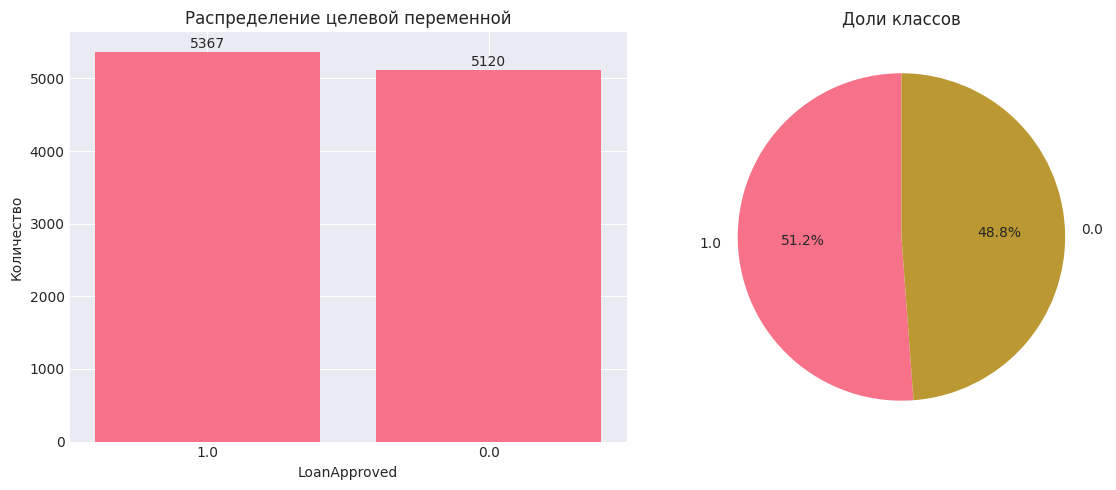

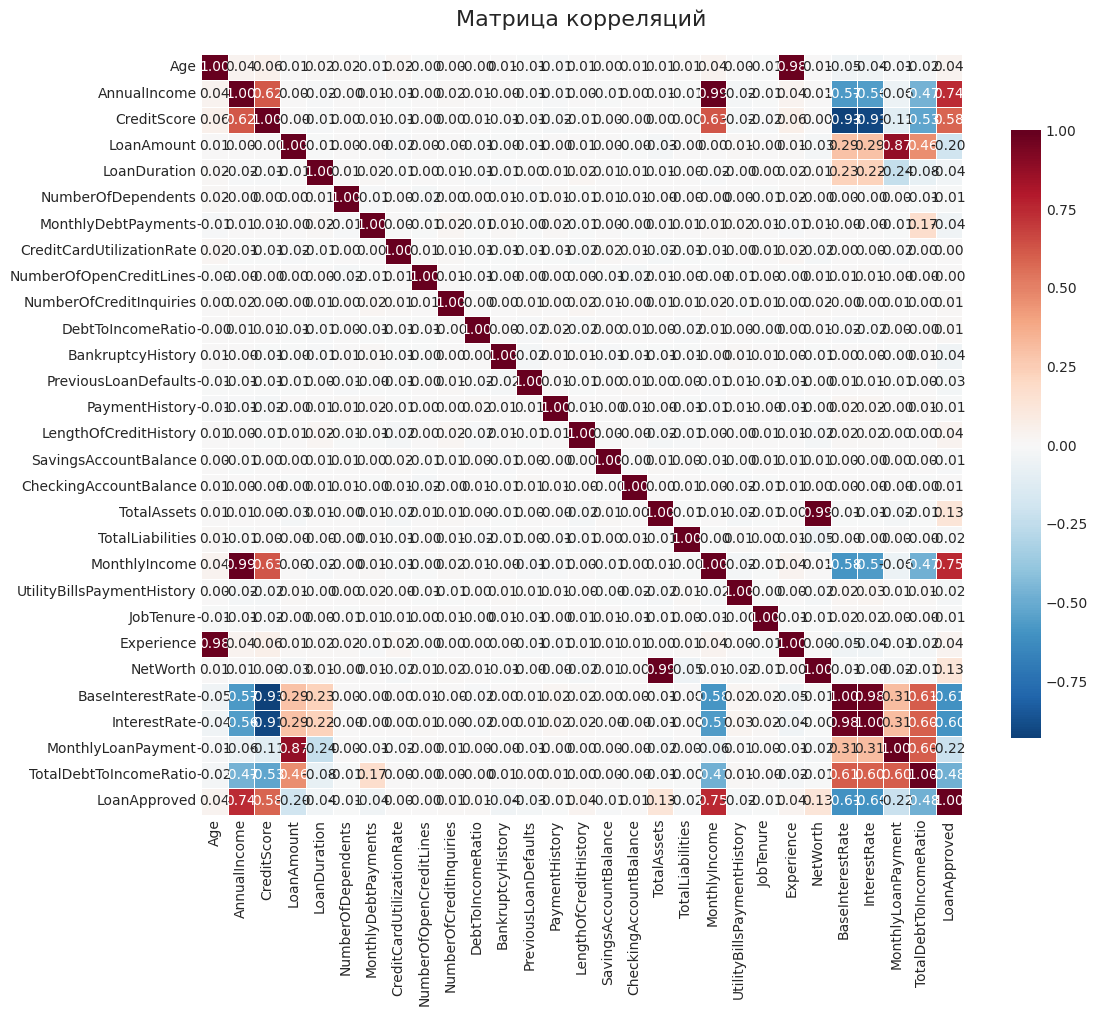


Сильные корреляции (|r| > 0.5):
TotalAssets - NetWorth: 0.994
AnnualIncome - MonthlyIncome: 0.985
Age - Experience: 0.983
BaseInterestRate - InterestRate: 0.975
CreditScore - BaseInterestRate: -0.932
CreditScore - InterestRate: -0.908
LoanAmount - MonthlyLoanPayment: 0.873
MonthlyIncome - LoanApproved: 0.755
AnnualIncome - LoanApproved: 0.743
CreditScore - MonthlyIncome: 0.628
AnnualIncome - CreditScore: 0.617
BaseInterestRate - TotalDebtToIncomeRatio: 0.605
BaseInterestRate - LoanApproved: -0.605
MonthlyLoanPayment - TotalDebtToIncomeRatio: 0.603
InterestRate - LoanApproved: -0.599
InterestRate - TotalDebtToIncomeRatio: 0.599
MonthlyIncome - BaseInterestRate: -0.585
CreditScore - LoanApproved: 0.582
AnnualIncome - BaseInterestRate: -0.575
MonthlyIncome - InterestRate: -0.568
AnnualIncome - InterestRate: -0.559
CreditScore - TotalDebtToIncomeRatio: -0.525


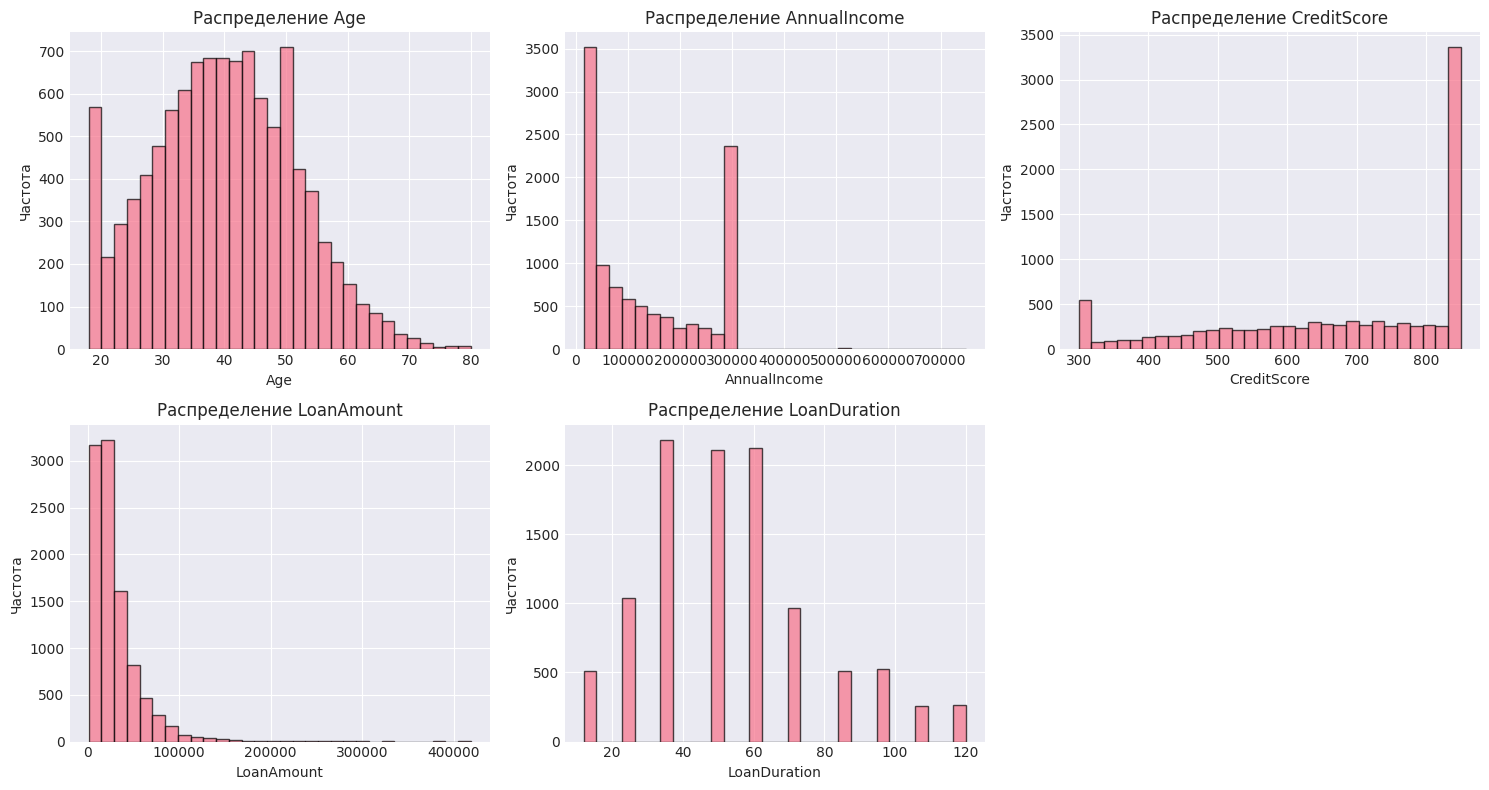

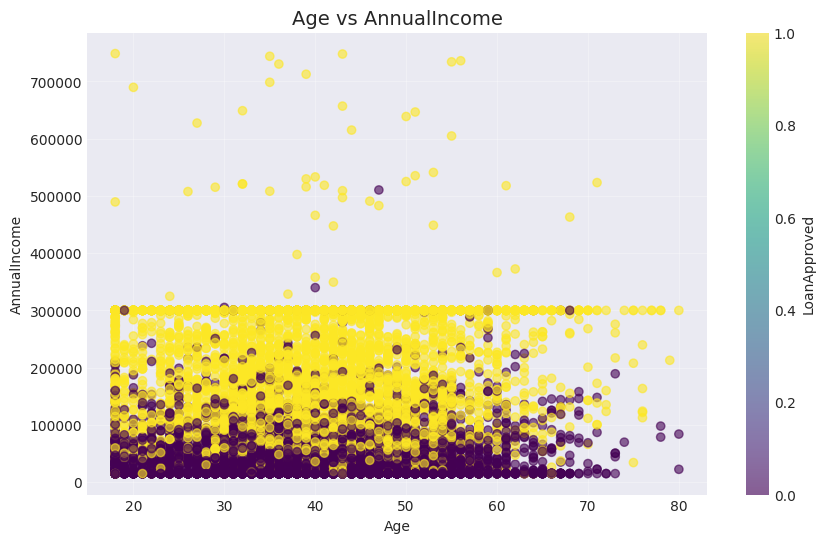


В целевой переменной найдено 530 NaN значений
Удаляем строки с NaN в целевой переменной...
После удаления: 10487 строк
В тестовых данных есть лишние колонки: {'ID'}
Сохраняем ID из тестовых данных для submission


2. Предобработка данных
Найдено признаков: 34
Категориальные признаки (13): ['ApplicationDate', 'LoanDuration', 'MaritalStatus', 'NumberOfDependents', 'HomeOwnershipStatus', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'BankruptcyHistory', 'LoanPurpose', 'PreviousLoanDefaults', 'JobTenure', 'EmploymentStatus', 'EducationLevel']
Числовые признаки (21): ['Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'DebtToIncomeRatio', 'PaymentHistory', 'LengthOfCreditHistory', 'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory', 'Experience', 'NetWorth', 'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio']
Предобрабо

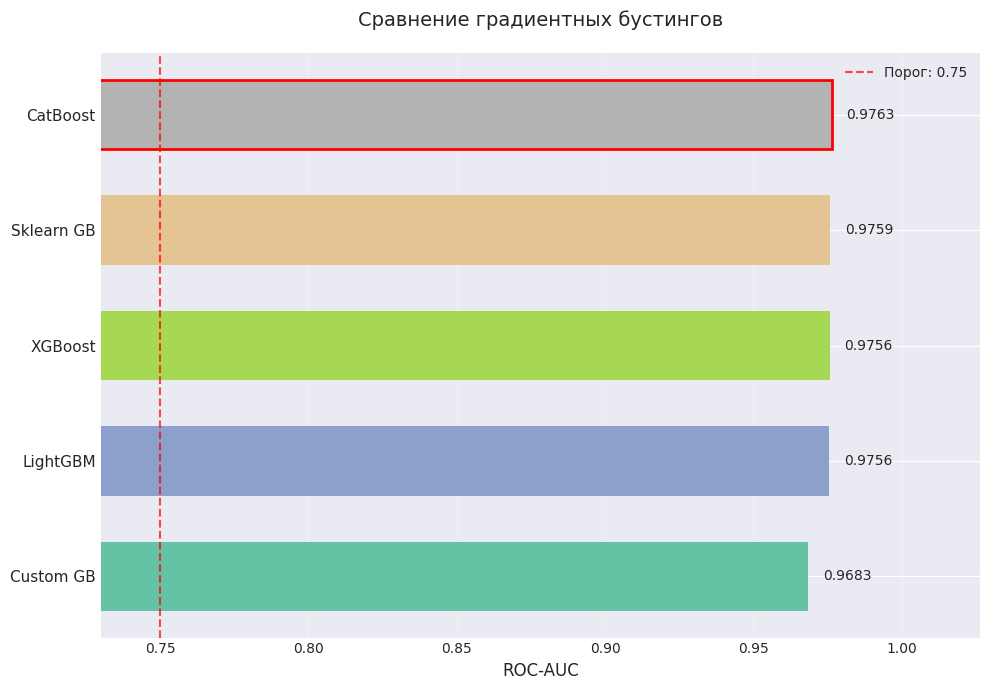


Строим ROC-кривые...


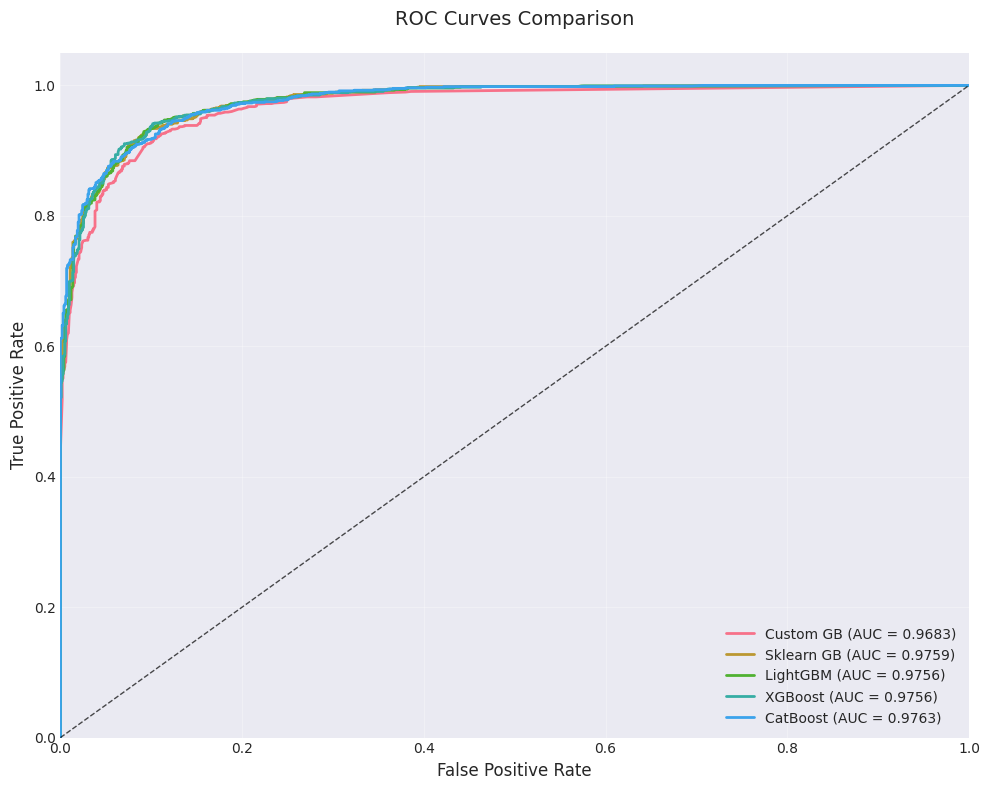

[I 2025-12-11 23:52:13,891] A new study created in memory with name: no-name-a35eff79-2de3-4461-b87b-19cfe141bc7d




6. Оптимизация гиперпараметров (optuna)
Optuna оптимизация (lightgbm)


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-11 23:52:14,103] Trial 0 finished with value: 0.9823464050861267 and parameters: {'n_estimators': 144, 'max_depth': 12, 'learning_rate': 0.1205712628744377, 'num_leaves': 98, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893, 'min_child_samples': 62}. Best is trial 0 with value: 0.9823464050861267.
[I 2025-12-11 23:52:14,179] Trial 1 finished with value: 0.9806542423184357 and parameters: {'n_estimators': 227, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'num_leaves': 129, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'reg_alpha': 4.4734294104626844e-07, 'reg_lambda': 5.472429642032198e-06, 'min_child_samples': 55}. Best is trial 0 with value: 0.9823464050861267.
[I 2025-12-11 23:52:14,312] Trial 2 finished with value: 0.9818999505353818 and parameters: {'n_estimators': 158, 'max_depth': 5, 'learning_rate': 0.08012737503998542, 'num_leaves': 38, 'sub

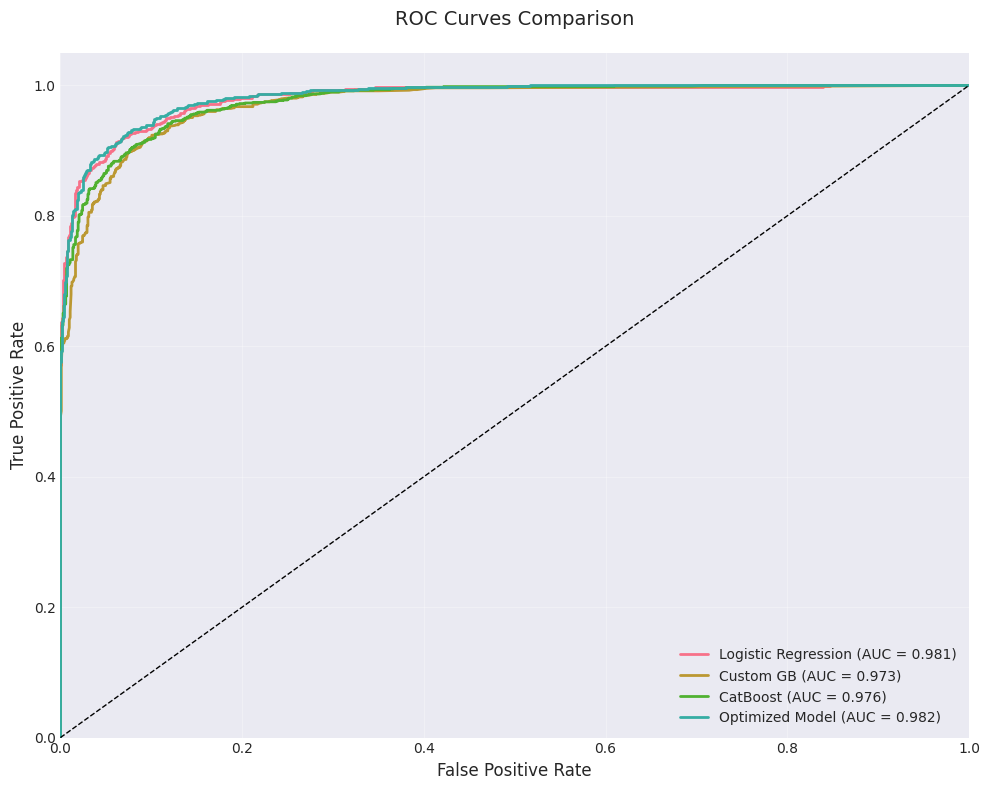

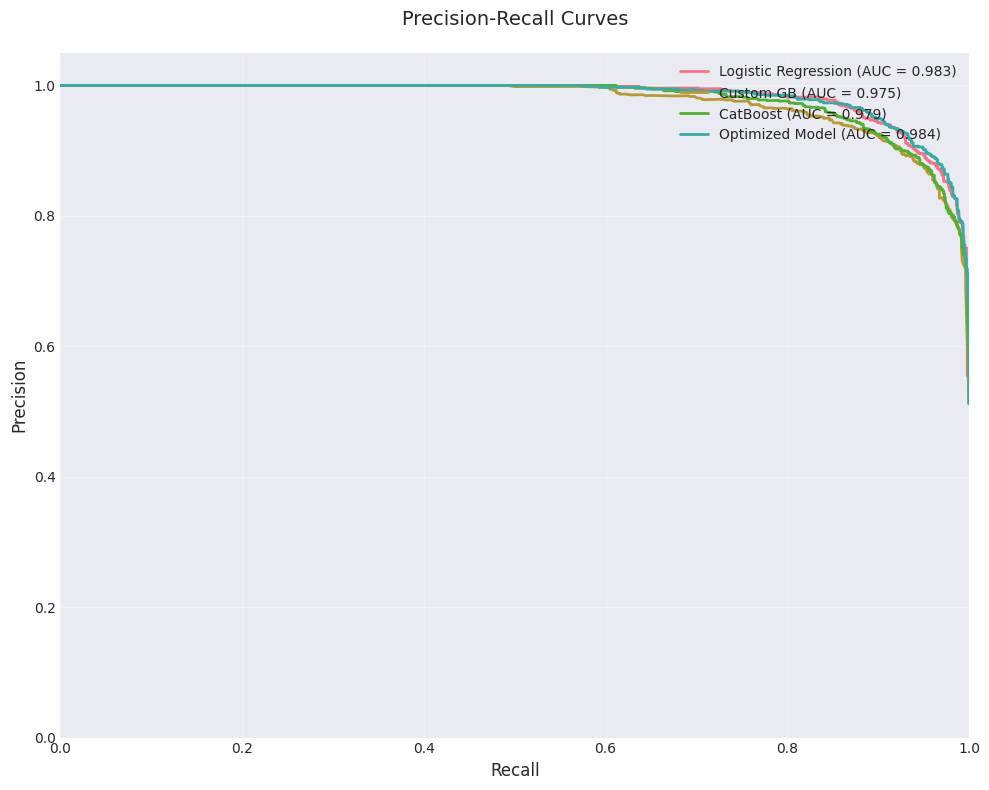

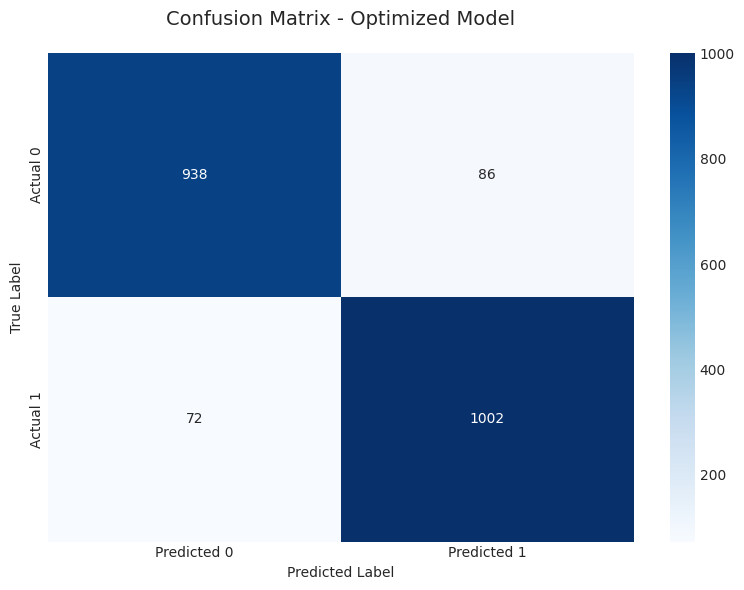

In [29]:
def main():
    print("\n1. Разведочный анализ данных (EDA)")
    try:
        analyzer = DataAnalyzer('train_c.csv', 'test_c.csv')
        train_df, test_df = analyzer.run_full_eda('LoanApproved')
    except FileNotFoundError as e:
        print(f"Файл не найден. Убедитесь, что train_c.csv и test_c.csv находятся в текущей директории.")
        print(f"Ошибка: {e}")
        return
    except Exception as e:
        print(f"Ошибка при выполнении EDA: {e}")
        return
    
    if 'LoanApproved' not in train_df.columns:
        print("Целевая переменная 'LoanApproved' не найдена в тренировочных данных")
        print("Доступные колонки:", list(train_df.columns))
        return
    
    nan_in_target = train_df['LoanApproved'].isnull().sum()
    if nan_in_target > 0:
        print(f"\nВ целевой переменной найдено {nan_in_target} NaN значений")
        print("Удаляем строки с NaN в целевой переменной...")
        train_df = train_df.dropna(subset=['LoanApproved'])
        print(f"После удаления: {len(train_df)} строк")
    
    train_cols = set(train_df.columns) - {'LoanApproved'}
    test_cols = set(test_df.columns)
    
    missing_in_test = train_cols - test_cols
    extra_in_test = test_cols - train_cols
    
    if missing_in_test:
        print(f"\nВ тестовых данных отсутствуют колонки из тренировочных: {missing_in_test}")
    
    if extra_in_test:
        print(f"В тестовых данных есть лишние колонки: {extra_in_test}")
        for col in extra_in_test:
            if col != 'ID': 
                if col in test_df.columns:
                    test_df = test_df.drop(columns=[col])
                    print(f"  Удалена колонка: {col}")
    
    if 'ID' in train_df.columns:
        print("Удаляем колонку ID из тренировочных данных")
        train_df = train_df.drop(columns=['ID'])
    
    if 'ID' in test_df.columns:
        print("Сохраняем ID из тестовых данных для submission")
        test_ids = test_df['ID'].copy()
        test_df = test_df.drop(columns=['ID'])
    else:
        test_ids = pd.RangeIndex(start=0, stop=len(test_df), step=1)
    
    print("\n\n2. Предобработка данных")
    preprocessor = RobustPreprocessor()
    
    try:
        X_scaled, y = preprocessor.fit_transform(train_df, 'LoanApproved')
        test_scaled = preprocessor.transform(test_df)
        print(f"Предобработка завершена успешно")
        
        if pd.isna(y).any():
            print("В целевой переменной все еще есть NaN после предобработки")
            nan_mask = pd.isna(y)
            X_scaled = X_scaled[~nan_mask]
            y = y[~nan_mask]
            print(f"Удалено {nan_mask.sum()} строк с NaN в целевой переменной")
            
    except Exception as e:
        print(f"Ошибка при предобработке данных: {e}")
        print("Попытка упрощенной предобработки...")
        
        X = train_df.drop('LoanApproved', axis=1)
        y = train_df['LoanApproved']
        
        nan_mask = y.isnull()
        if nan_mask.any():
            print(f"Удаляем {nan_mask.sum()} строк с NaN в целевой переменной")
            X = X[~nan_mask]
            y = y[~nan_mask]
        
        categorical_cols = X.select_dtypes(include=['object']).columns
        
        for col in categorical_cols:
            if col in X.columns and col in test_df.columns:
                combined = pd.concat([X[col], test_df[col]], ignore_index=True)
                combined = combined.fillna('missing').astype(str)
                le = LabelEncoder()
                le.fit(combined)
                
                X[col] = le.transform(X[col].fillna('missing').astype(str))
                test_df[col] = le.transform(test_df[col].fillna('missing').astype(str))
        
        X = X.fillna(X.median())
        test_df = test_df.fillna(test_df.median())
        
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        test_scaled = scaler.transform(test_df)
        
        print("Упрощенная предобработка завершена")
    
    if pd.isna(y).any():
        print("В целевой переменной все еще есть NaN. Удаляем эти строки...")
        nan_mask = pd.isna(y)
        X_scaled = X_scaled[~nan_mask]
        y = y[~nan_mask]
    
    print(f"\nРазмеры данных после очистки:")
    print(f"  X_scaled: {X_scaled.shape}")
    print(f"  y: {y.shape}")
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_scaled, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )
    
    print(f"\nРазмеры данных после разделения:")
    print(f"  Train: {X_train.shape}")
    print(f"  Val:   {X_val.shape}")
    print(f"  Test:  {test_scaled.shape}")
    
    print("\n\n3. Тестирование кастомных метрик")
    
    from sklearn.linear_model import LogisticRegression
    baseline_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
    baseline_model.fit(X_train, y_train)
    y_pred_baseline = baseline_model.predict(X_val)
    y_pred_proba_baseline = baseline_model.predict_proba(X_val)[:, 1]
    
    try:
        metrics_comparison = CustomMetrics.compare_with_sklearn(
            y_val, y_pred_baseline, y_pred_proba_baseline
        )
    except Exception as e:
        print(f"Ошибка при тестировании метрик: {e}")
    
    print("\n\n4. Кастомный бэггинг")
    try:
        custom_bag = CustomBaggingClassifier(
            base_estimator=DecisionTreeClassifier(max_depth=5),
            n_estimators=20,
            random_state=RANDOM_STATE
        )
        custom_auc, sklearn_auc = custom_bag.compare_with_sklearn(X_train, y_train, X_val, y_val)
    except Exception as e:
        print(f"Ошибка при работе с бэггингом: {e}")
        custom_auc = sklearn_auc = 0.5
    
    print("\n\n5. Градиентный бустинг")
    
    try:
        custom_gb = CustomGradientBoosting(
            n_estimators=50,
            learning_rate=0.1,
            max_depth=3,
            random_state=RANDOM_STATE
        )
        custom_gb.fit(X_train, y_train)
        y_pred_custom_gb = custom_gb.predict_proba(X_val)[:, 1]
        custom_gb_auc = roc_auc_score(y_val, y_pred_custom_gb)
        print(f"Custom Gradient Boosting ROC-AUC: {custom_gb_auc:.4f}")
    except Exception as e:
        print(f"Ошибка в кастомном градиентном бустинге: {e}")
        custom_gb_auc = 0.5
    
    try:
        comparator = GradientBoostingComparator()
        gb_results, best_gb_name, best_gb_model = comparator.compare_models(
            X_train, y_train, X_val, y_val, n_estimators=30, learning_rate=0.1
        )
    except Exception as e:
        print(f"Ошибка при сравнении градиентных бустингов: {e}")
        best_gb_model = lgb.LGBMClassifier(random_state=RANDOM_STATE, verbosity=-1, n_estimators=30)
        best_gb_model.fit(X_train, y_train)
        best_gb_name = "LightGBM (резервная)"
    
    print("\n\n6. Оптимизация гиперпараметров (optuna)")
    
    try:
        optimizer = HyperparameterOptimizer(X_train, y_train, X_val, y_val)
        best_model, best_params, best_auc = optimizer.optimize(
            model_type='lightgbm', 
            n_trials=10
        )
    except Exception as e:
        print(f"Ошибка при оптимизации Optuna: {e}")
        print("Использование LightGBM с дефолтными параметрами...")
        best_model = lgb.LGBMClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            random_state=RANDOM_STATE,
            verbosity=-1
        )
        best_model.fit(X_train, y_train)
        y_pred_best = best_model.predict_proba(X_val)[:, 1]
        best_auc = roc_auc_score(y_val, y_pred_best)
        best_params = {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 6}
        print(f"ROC-AUC с дефолтными параметрами: {best_auc:.4f}")
    
    if best_auc >= THRESHOLD_AUC:
        print(f"\nПорог пройден! ROC-AUC = {best_auc:.4f} >= {THRESHOLD_AUC}")
    else:
        print(f"\nПорог не пройден! ROC-AUC = {best_auc:.4f} < {THRESHOLD_AUC}")
        print("Необходимо улучшить модель")
    
    print("\n\n7. Обучение финальной модели")
    
    try:
        if best_params:
            final_model = lgb.LGBMClassifier(**best_params, random_state=RANDOM_STATE, verbosity=-1)
        else:
            final_model = lgb.LGBMClassifier(random_state=RANDOM_STATE, verbosity=-1)
        
        final_model.fit(X_scaled, y)
        
        test_predictions = final_model.predict_proba(test_scaled)[:, 1]
        
        submission_df = pd.DataFrame({
            'ID': test_ids,
            'LoanApproved': test_predictions
        })
        submission_df.to_csv('submission.csv', index=False)
    except Exception as e:
        submission_df = pd.DataFrame({
            'ID': test_ids,
            'LoanApproved': [0.5] * len(test_ids) 
        })
        submission_df.to_csv('submission.csv', index=False)
    
    print("\n\n8. Визуализация результатов")
    
    try:
        visualizer = ResultsVisualizer()
        
        models_for_viz = {
            'Logistic Regression': baseline_model,
            'Custom GB': custom_gb if 'custom_gb' in locals() else None,
            best_gb_name: best_gb_model,
            'Optimized Model': best_model
        }
        
        y_pred_probas = []
        model_names = []
        
        for name, model in models_for_viz.items():
            if model is not None and hasattr(model, 'predict_proba'):
                try:
                    y_pred_proba = model.predict_proba(X_val)[:, 1]
                    y_pred_probas.append(y_pred_proba)
                    model_names.append(name)
                except:
                    continue
        
        if len(y_pred_probas) > 1:
            visualizer.plot_roc_curve(y_val, y_pred_probas, model_names)
            
            visualizer.plot_pr_curve(y_val, y_pred_probas, model_names)
            
            y_pred_best = (best_model.predict_proba(X_val)[:, 1] > 0.5).astype(int)
            visualizer.plot_confusion_matrix(y_val, y_pred_best, 'Optimized Model')
        else:
            print("Недостаточно моделей для визуализации")
    except Exception as e:
        print(f"Ошибка при визуализации: {e}")    

if __name__ == "__main__":
    main()